In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint

import itertools
import scipy
import scipy.integrate as spi
from scipy.integrate import quad
from scipy.special import erf,erfc
#import cvxpy as cp

from sympy import symbols, solve
from scipy.optimize import fsolve, root
from numpy.polynomial import polynomial as P

In [2]:
print(scipy.__version__)

1.10.1


V= 0.6931471805599453


/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_64711/1708578169.py:21: RuntimeWarning: invalid value encountered in log
  log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_64711/1708578169.py:22: RuntimeWarning: invalid value encountered in log
  log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)


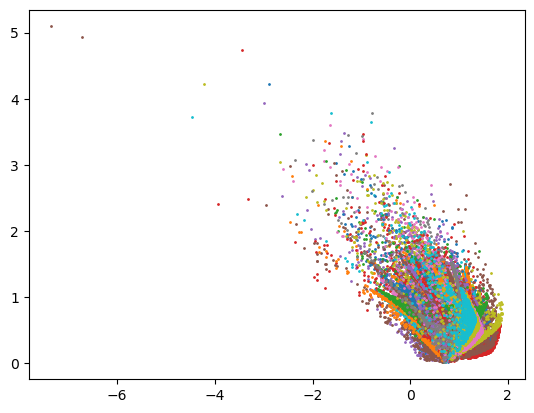

In [3]:
r=1/2*np.array([0.7,0.1,0.2])

V=-np.log(sum(r))
print("V=",V)
p=np.zeros((1,3))
num_p=100
num_b=1000
for j in range(num_p):
  Wnonopt=[]
  sigmanonopt=[]
  p0=random.uniform(0,1)
  p1=random.uniform(0,1)
  p2=random.uniform(0,1)
  sum_p=p0+p1+p2
  p=np.array([p0,p1,p2])/sum_p
  for i in range(num_b):
          b0=random.uniform(0.1, 1) #low, high
          b1=random.uniform(0.1,b0)
          b2=1-b1-b0
          if b2!=0:
              log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
              log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
              Wnonopt.append(np.dot(p,log))
              sigmanonopt.append(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
  Wnonopt=np.array(Wnonopt)
  sigmanonopt=np.array(sigmanonopt)
  plt.scatter(Wnonopt,sigmanonopt,s=1)
#print(Wnonopt)


In [4]:
#FOR 3 HORSES

def optWsigma(r,p,a):

    def J(b,a=a,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        log2=((np.log(b[0]/r[0]))**2,(np.log(b[1]/r[1]))**2,(np.log(b[2]/r[2]))**2)
        return -a*np.dot(p,log)+(1-a)*np.sqrt((np.dot(p,log2)-(np.dot(p,log))**2))

    def constraint(b):
        return np.sum(b)-1

    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]


    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint}


    # Minimize the negative of the objective function
    res = minimize(J, [1/3, 1/3, 1/3], bounds=bounds, constraints=constraint_dict_eq, options={'maxiter':10000})
    #print(res.x)

    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun

    return res.x


In [2]:
alpha=np.linspace(0,1,20)

b0_opt=np.zeros_like(alpha)
b1_opt=np.zeros_like(alpha)
b2_opt=np.zeros_like(alpha)
W_opt=np.zeros_like(alpha)
sigma_opt=np.zeros_like(alpha)
P_ext_J=np.zeros_like(alpha)

#p=(0.1,0.2,0.7)
#r=(0.7,0.1,0.2)
    

    #Minimize J using defined function
    for i in range(0,len(alpha)):
      b0_opt[i],b1_opt[i],b2_opt[i]=optWsigma(r,p,alpha[i])
      log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
      log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
      W_opt[i]=(np.dot(p,log))
      sigma_opt[i]=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    #Simulation with optimal b's
    num_realizations=10000
    num_races=100;

    def horse_wins(p):
      limits=np.cumsum(p)
      random_num=(random.uniform(0,1))
      #print(random_num)
      check=(random_num<=limits)
      indice_caballo=0
      while ~check[indice_caballo]:
        indice_caballo+=1
      return indice_caballo

    threshold=np.log(0.6)
    initial_capital=1
    for i in range(0,len(alpha)):
      b=np.array([b0_opt[i],b1_opt[i],b2_opt[i]])
      #b=p#Kelly's
      print("alpha= ",alpha[i])
      print("b=[",b,"]")
      print("Deltas:",np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
      log_capital=np.zeros(num_races);
      log_capital[0]=np.log(initial_capital)
      extinctions=0
      for j in range(0,num_realizations-1): #realizations for
        for k in range(1,num_races): #races for loop
          #Which horse wins
          #print(check)
          horse=horse_wins(p)
          #print("horse wins:",horse)
          #Compute capital
          log_capital[k]=log_capital[k-1]+np.log(b[horse]/r[horse])
          if log_capital[k]<=threshold:
            extinctions=extinctions+1
            break #we can stop simulating once is extinct
        #plt.plot(log_capital)
        P_ext_J[i]=extinctions/num_realizations
      #print("Num Extinctions: ",extinctions)
      print("P_ext: ",P_ext_J[i])
    #print(alpha)
    #print(P_ext_J)
    plt.plot(alpha,P_ext_J)
    plt.xlabel('alpha')
    plt.ylabel('P_ext')
    log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
    print(np.dot(p,log))

NameError: ignored

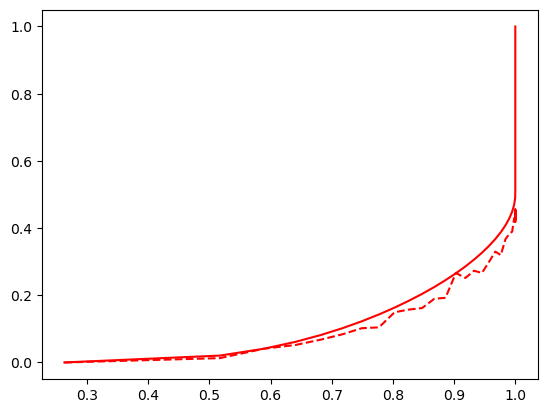

In [22]:
plt.plot(W_opt/max(W_opt),P_ext_J,'r--') #P_ext_J,W_opt/max(W_opt),betas)
plt.plot(W_opt/max(W_opt),betas,'r')

0
beta=  0.0001


/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_64711/910920072.py:4: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_64711/910920072.py:10: RuntimeWarning: divide by zero encountered in scalar power
  return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1


beta=  0.02050612244897959
beta=  0.04091224489795919
beta=  0.06131836734693878
beta=  0.08172448979591837
beta=  0.10213061224489796
beta=  0.12253673469387756
beta=  0.14294285714285712
beta=  0.16334897959183672
beta=  0.18375510204081633
beta=  0.2041612244897959
beta=  0.2245673469387755
beta=  0.2449734693877551
beta=  0.2653795918367347
beta=  0.28578571428571425
beta=  0.30619183673469386
beta=  0.32659795918367346
beta=  0.34700408163265306
beta=  0.36741020408163266
beta=  0.3878163265306122
beta=  0.4082224489795918
beta=  0.4286285714285714
beta=  0.449034693877551
beta=  0.4694408163265306
beta=  0.4898469387755102
beta=  0.5102530612244898
beta=  0.5306591836734694
beta=  0.551065306122449
beta=  0.5714714285714285
beta=  0.5918775510204082
beta=  0.6122836734693877
beta=  0.6326897959183674
beta=  0.6530959183673469
beta=  0.6735020408163265
beta=  0.6939081632653061
beta=  0.7143142857142857
beta=  0.7347204081632653
beta=  0.7551265306122449
beta=  0.7755326530612244


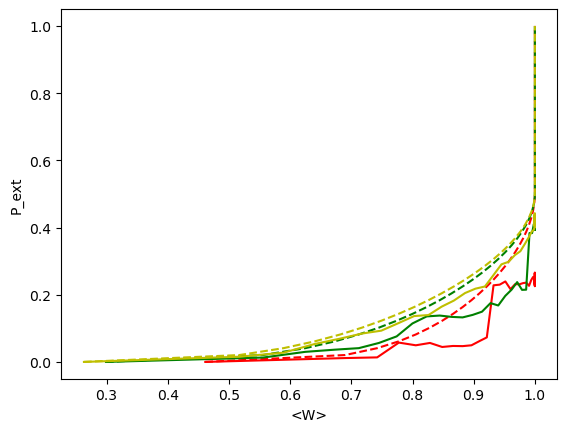

In [24]:
betas=np.linspace(0.0001,1,50)
color_tab=['r','g','b','m']
color_tab2=['r--','g--','b--','m--']
b0_opt=np.zeros_like(betas)
b1_opt=np.zeros_like(betas)
b2_opt=np.zeros_like(betas)
W_opt=np.zeros_like(betas)
sigma_opt=np.zeros_like(betas)
P_ext_J=np.zeros_like(betas)

for l in range(0,3):
    print(l)
    p=np.random.uniform(0,1,3)
    p/=sum(p)  
    r=np.random.uniform(0,1,3)
    r/=sum(r)

    alpha=0.5
    #Maximize W with constraints using maxim()
    for i in range(0,len(betas)):
      waux,sigmaaux,[b0_opt[i],b1_opt[i],b2_opt[i]]=maxim(r,p,betas[i],alpha)
      b0=b0_opt[i]
      b1=b1_opt[i]
      b2=b2_opt[i]
      log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
      log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
      W_opt[i]=(np.dot(p,log))
      sigma_opt[i]=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))

    #Simulation with optimal b's
    num_realizations=2000
    num_races=100;

    def horse_wins(p):
      limits=np.cumsum(p)
      random_num=(random.uniform(0,1))
      #print(random_num)
      check=(random_num<=limits)
      indice_caballo=0
      while ~check[indice_caballo]:
        indice_caballo+=1
      return indice_caballo

    threshold=np.log(alpha)
    initial_capital=1
    for i in range(0,len(betas)):
      b=np.array([b0_opt[i],b1_opt[i],b2_opt[i]])
      #b=p#Kelly's
      #print(f"--Iteration {i} of {len(betas)}--")
      print("beta= ",betas[i])
      #print("b=[",b,"]")
      #print("Deltas:",np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
      log_capital=np.zeros(num_races);
      log_capital[0]=np.log(initial_capital)
      extinctions=0
      for j in range(0,num_realizations-1): #realizations for
        for k in range(1,num_races): #races for loop
          #Which horse wins
          #print(check)
          horse=horse_wins(p)
          #print("horse wins:",horse)
          #Compute capital
          log_capital[k]=log_capital[k-1]+np.log(b[horse]/r[horse])
          if log_capital[k]<=threshold:
            extinctions=extinctions+1
            break #we can stop simulating once is extinct
        #plt.plot(log_capital)
        P_ext_J[i]=extinctions/num_realizations
      #print("Num Extinctions: ",extinctions)
      #print("P_ext: ",P_ext_J[i])
    #print(alpha)
    #print(P_ext_J)
    plt.plot(W_opt/max(W_opt),P_ext_J,color_tab[l])
    plt.plot(W_opt/max(W_opt),betas,color_tab2[l])
plt.xlabel('<W>')
plt.ylabel('P_ext')
log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
print(np.dot(p,log))


In [4]:
def W_sigma(r,p,filename):
    par=np.linspace(0,1,100)
    W=[]
    sigma=[]
    Wnonopt=[]
    sigmanonopt=[]
    for a in par:
        b0,b1,b2=optWsigma(r,p,a)
        print(b0,b1,b2)
        log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
        log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
        W.append(np.dot(p,log))
        sigma.append(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))

        if a==1:
            kellyw=np.dot(p,log)
            kellys=np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2)

    #print(W)
    for i in range(1000):
        b0=random.uniform(0.1, 1) #low, high
        b1=random.uniform(0.1,b0)
        b2=1-b1-b0
        if b2!=0:
            log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
            log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
            Wnonopt.append(np.dot(p,log))
            sigmanonopt.append(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    Wnonopt=np.array(Wnonopt)
    sigmanonopt=np.array(sigmanonopt)
    #print(Wnonopt)

    plt.scatter(Wnonopt,sigmanonopt)
    plt.plot(W,sigma,'r',linewidth=3)
    plt.scatter([kellyw],[kellys],color='yellow',s=150)
    plt.scatter([0],[0],color='green',s=300)
    plt.xlabel('Average Growth Rate')
    plt.xlim(-0.01,1)
    plt.ylabel('Volatility')
    plt.ylim(-0.01,1.25)
    plt.savefig(filename)
    #plt.show()
    return W,sigma

In [ ]:
#Defining the survival probability

def S2(t,B,x0,u,var):
    return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
def S1(t,B,x0,u,var): #just another way to write it
    return 0.5*erfc((B-x0-u*t)/(np.sqrt(var*2*t)))-0.5*np.exp(-(2*u*(x0-B))/(var))*erfc((x0-B-u*t)/(np.sqrt(var*2*t)))

In [5]:
def maxim(r,p,beta,alpha):

    def Delta(b,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        return -np.dot(p,log)

    lamb=np.log(beta)/np.log(alpha)

    def constraint1(b,r=r,p=p,lamb=lamb):
        return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1

    def constraint2(b):
        return np.sum(b)-1

    nonlinear_constraint = NonlinearConstraint(constraint1, lb=float('-inf'), ub=0)

    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]

    #constraint_dict_ineq = {'type': 'ineq', 'fun': constraint1}

    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint2}


    # Minimize the negative of the objective function
    res = minimize(Delta, [1/3, 1/3, 1/3], bounds=bounds, constraints=[nonlinear_constraint, constraint_dict_eq])
    #print(res.x)

    log=(np.log(res.x[0]/r[0]),np.log(res.x[1]/r[1]),np.log(res.x[2]/r[2]))
    log2=((np.log(res.x[0]/r[0]))**2,(np.log(res.x[1]/r[1]))**2,(np.log(res.x[2]/r[2]))**2)
    sigma=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun

    return max_value,sigma,res.x

In [ ]:
def E_Pext(r,p,alpha):

    r=np.array(r)
    p=np.array(p)
    betas=np.linspace(0.0001,1,100)
    wealth=[]
    sigma=[]

    for beta in betas:
        optwealth,sigmax=maxim(r,p,beta,alpha)
        wealth.append(optwealth)
        sigma.append(sigmax)
        #print(wealth)
    #print(wealth[-1])
        if beta==1:
            kw,ks=maxim(r,p,beta,alpha)


    #plt.plot(wealth,sigma,'g',label='Pareto front for mean-extinction trade-off')


    #plt.xlabel('<W>')
    #plt.xlim(0,0.20)
    #plt.ylabel('Volatility')
    #plt.ylim(0,0.0001)
    #plt.legend()
    #plt.savefig('pareto_tradeoff.pdf')
    #plt.show()

    #Plot the dashed line at Kelly's <W>
    line,=plt.plot(kw*np.ones(len(betas)),betas,c='g', label="Kelly's <W>",linestyle='dashed')
    line.set_color('black')

    plt.plot(wealth,betas,'g',label='Pext BOYD')
    plt.xlabel('<W>')
    #plt.xlim(0,0.20)
    plt.ylabel('Pext')
    #plt.ylim(0,0.0001)
    plt.legend()
    #plt.show()

    #plt.plot(sigma,betas,'b',label='Pext for mean-extinction trade-off')
    #plt.xlabel('σW ')
    #plt.xlim(0,0.20)
    #plt.ylabel('Pext')
    #plt.ylim(0,0.0001)

    #Dinis:return "wealth", that is, <W> optimal for computing P_ext
    return sigma,betas,ks,wealth

In [ ]:
np.exp(5.5*np.log(0.7))


0.14061745065958203

In [ ]:
#DOING THE MAXIMIZATION OF W WITH THE CONSTRAINT OF P_EXT BUT USING KKT CONDITIONS

def maximKKT(r,p,beta,alpha):

    lamb=np.log(beta)/np.log(alpha)

    #case without constraint:

    check=(p[0]*(p[0]/r[0])**(-lamb)+p[1]*(p[1]/r[1])**(-lamb)+p[2]*(p[2]/r[2])**(-lamb))

    if check < 1:
        #print('kelly with beta',beta)
        return p[0],p[1],p[2] #kelly's strategy satisfies the problem

    #case with constraint:

    def equations(vars):
        b0, b1, b2, k, u = vars
        eq1 = p[0]/b0*(1+k*lamb*(b0/r[0])**(-lamb))+u
        eq2 = p[1]/b1*(1+k*lamb*(b1/r[1])**(-lamb))+u
        eq3 = p[2]/b2*(1+k*lamb*(b2/r[2])**(-lamb))+u
        eq4 = b0+b1+b2-1
        eq5=(p[0]*(b0/r[0])**(-lamb)+p[1]*(b1/r[1])**(-lamb)+p[2]*(b2/r[2])**(-lamb))-1
        return [eq1, eq2, eq3, eq4, eq5]
    initial_guess = [0.1, 0.2, 0.7, 0.0756, -1]  # Initial guess for the solution (you have to vary yourself the initial guess for the lagr multiplier)
    solution = fsolve(equations, initial_guess)
    #print(solution,beta)

    if solution[0]>0 and solution[1]>0 and solution[2]>0 and solution[3]>0:
        #print(solution[0],solution[1],solution[2], 'with beta', beta)

        return solution[0],solution[1],solution[2]

def E_Pext_KKT(r,p,alpha):

    r=np.array(r)
    p=np.array(p)
    betas=np.linspace(0.002,1,100)
    wealth=[]
    sigma=[]

    for beta in betas:
        b0,b1,b2=maximKKT(r,p,beta,alpha)

        log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
        log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
        optwealth= np.dot(p,log)
        optsigma= (np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
        wealth.append(optwealth)
        sigma.append(optsigma)
        #print(wealth)
    #print(wealth[-1])

    plt.plot(wealth,sigma,'g',label='Pareto front for risk-constrained with KKT')
    plt.xlabel('Wealth')
    plt.xlim(0.4,0.85)
    plt.ylabel('volatility')
    #plt.ylim(0,0.0001)
    plt.legend()
    plt.show()

    plt.plot(wealth,betas,'b',label='Pext for risk-constrained with KKT')
    plt.xlabel('Wealth')
    plt.xlim(0.4,0.85)
    plt.ylabel('P_ext')
    #plt.ylim(0,0.0001)
    plt.legend()
    plt.show()
p=(0.1,0.2,0.7)
r=(0.7,0.1,0.2)
alpha=0.78
print('using KKT minimization')
##E_Pext_KKT(r,p,alpha)
print('using preimplemented minimization')
##E_Pext(r,p,alpha)
plt.show()

#As expected, when beta goes to 1 (P_ext) the best strategy is Kelly's one, hence the wealth is computed as the Kelly's one.
#Let's compare this plot with the theoretical extinction probability one obtains theoretically with the optimal b's obtained by the VARIANCE-W
#trade-off, indeed let's find the optimal values to create the pareto front for 3 horses, so with the method we've always used:
#THE KKT MAXIMIZATION IS SHOWN AFTER W=0.4 BECAUSE BEFORE THERE'S TOO MUCH DEPENDENCE ON THE INITIAL VALUE OF THE LAGRANGE MULTIPLIER, SO THE RESULTS ARE NOT AS GOOD AS 'minimize' FUNCTION

using KKT minimization
using preimplemented minimization


In [ ]:
#COMPARING THE VOLATILITY AS RISK WRT EXTINCTION AS RISK FOR THE GRAPH W-P_ext

In [ ]:
p=(0.1,0.2,0.7)
r=(0.7,0.1,0.2)
#W,sigma=W_sigma(r,p,'3horses.pdf')
#print(W)
#print(sigma)

<ipython-input-13-73552b656af5>:4: RuntimeWarning: overflow encountered in exp
  return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
<ipython-input-13-73552b656af5>:4: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5*(1-erf((B-x0-u*t)/(np.sqrt(var*2*t))))-np.exp(-(2*u*(x0-B))/(var))*0.5*(1+erf((B-x0+u*t)/(np.sqrt(var*2*t))))
<ipython-input-14-ff1247e2d13d>:4: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
<ipython-input-14-ff1247e2d13d>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1


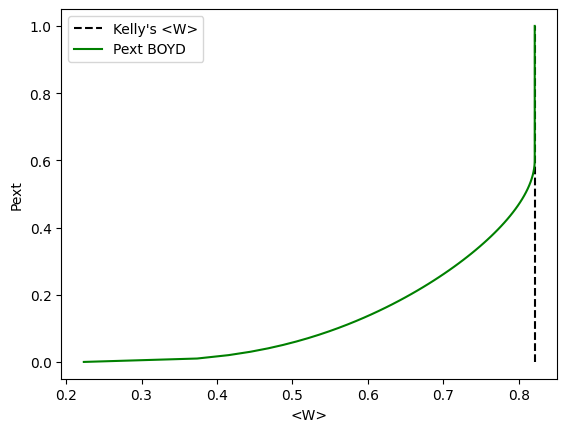

In [ ]:
p=(0.1,0.2,0.7)
r=(0.7,0.1,0.2)
x0=1
t=100
alpha=0.6      #for an alpha of 0.9 to mimic the result one needs x0-B= 0.06 so B= 0.94
                    #for an aplha of 0.78 to mimic the result one needs x0-B= 0.13 so B= 0.87
                     #for an alpha of 0.5 to mimic one needs x0-B= 0.38 so B= 0.62
             #for an alpha of 0.3 to mimic one need x0-B= 0.66 so B= 0.34
                     #for an alpha of 0.1 to mimic one needs x0-B almost 1 so B=0

B=0.6

kellyw=np.max(W)
kellys=np.max(sigma)

P_ext=np.ones(len(W))
for i in range(len(W)):
    #Dinis: Computation of P_ext, using W and sigma from mean-var optimization in previous cell
    u=W[i]
    var=(sigma[i])**2
    P_ext[i]=1-S2(t,B,x0,u,var)

#plt.plot(W,sigma,'y',label='Pareto front for mean-vol trade-off')
#plt.scatter([kellyw],[kellys],color='black',s=50,marker='s',label="Kelly's strategy")
#plt.scatter([0],[0],color='black',s=50,label='Null-strategy')
#plt.title('(a)')
#plt.legend()
#plt.savefig('Pareto.pdf')


sigma1,betas,ks,W1=E_Pext(r,p,alpha)
B=round(B,2)
#plt.plot(W,P_ext,'r',label='Pext for mean-vol trade-off')
#plt.title('(b)')


#Added by Dinis
#---------
P_ext_fromW1sigma1=np.ones(len(W1))
for i in range(len(W1)):
    #Dinis: Computation of P_ext, using W and sigma from mean-var optimization in previous cell
    u=W1[i]
    var=(sigma1[i])**2
    P_ext_fromW1sigma1[i]=1-S2(t,B,x0,u,var)
#plt.plot(W1,P_ext_fromW1sigma1,'b',label='Pext vs W from beta problem using GMB')
#------
#plt.legend()
#plt.savefig('Pext_tradeoff_{}.pdf'.format(B))
#plt.show()


#From here, 3rd plot Pext vs var

#plt.plot(sigma1,betas,color='y',label='Pext-volatility relation for mean-vol trade-off')

#plt.savefig('Ps1.pdf')

#This for loop is duplicated and Pext is computed earlier, can be commented out.
#for i in range(len(W)):
#    u=W[i]
#    var=(sigma[i])**2
#    P_ext[i]=1-S2(t,B,x0,u,var)


#plt.plot(sigma1,Pext,color='b',label='Pext-volatility relation for mean-vol trade-off')

#plt.plot(sigma,P_ext,color='g',label='Pext-volatility relation for mean-extinction trade-off')
#line,=plt.plot(ks*np.ones(len(betas)),betas,c='g', label="Kelly's σw",linestyle='dashed')
#line.set_color('black')
#plt.title('(c)')
#plt.xlabel('σw ')
#plt.xlim(0,0.20)
#plt.ylabel('Pext')
#plt.legend()
#plt.savefig('Ps.pdf')
